# PUBG Kaggle

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import preprocessing
from sklearn.decomposition import PCA
import pprint

%matplotlib inline

In [2]:
# Read CSV files
train = pd.read_csv("train_V2.csv")
test = pd.read_csv("test_V2.csv")

#train.drop(train['winPlacePerc'].isnull().index, axis=0, inplace=True)
train.drop(2744604, inplace=True)

trainId = train['Id']
testId  = test['Id']

train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

train.head()

,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 28 columns):
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(3)
memory usage: 983.9+ MB


In [4]:
# Concat training and set set for data exploration and feature engineering
y_train = train['winPlacePerc']

all_data = pd.concat((train.loc[:,'groupId':'winPoints'],
                     test.loc[:,'groupId':'winPoints']))
all_data.shape

(6381139, 27)

In [5]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


In [6]:
print("The average person kills {:.4f} players, 99% of people have {} kills or less, while the most kills ever recorded is {}.".format(train['kills'].mean(),train['kills'].quantile(0.99), train['kills'].max()))

The average person kills 0.9248 players, 99% of people have 7.0 kills or less, while the most kills ever recorded is 72.


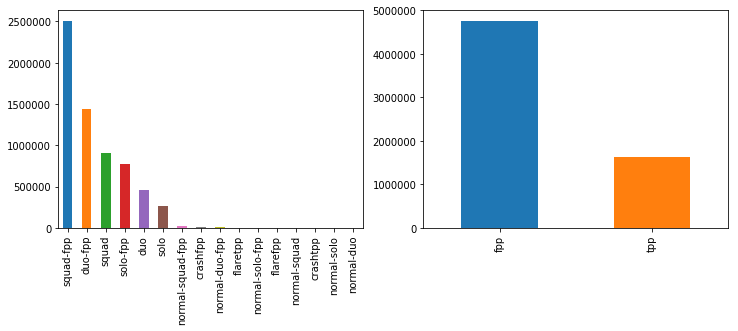

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

all_data['matchType'].value_counts().plot.bar(ax=ax[0])

'''
solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp
duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp
squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp
'''
mapper = lambda x: 'fpp' if ('fpp' in x) else 'tpp'
all_data["perspective"] = all_data['matchType'].apply(mapper)
all_data["perspective"].value_counts().plot.bar(ax=ax[1])

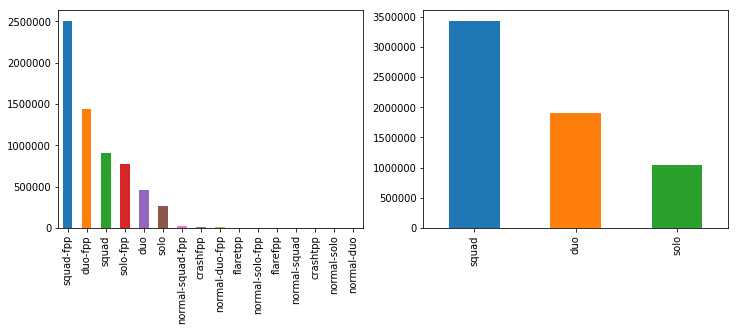

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

all_data['matchType'].value_counts().plot.bar(ax=ax[0])

'''
solo  <-- solo,solo-fpp,normal-solo,normal-solo-fpp
duo   <-- duo,duo-fpp,normal-duo,normal-duo-fpp,crashfpp,crashtpp
squad <-- squad,squad-fpp,normal-squad,normal-squad-fpp,flarefpp,flaretpp
'''
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
all_data["matchType"] = all_data['matchType'].apply(mapper)
all_data["matchType"].value_counts().plot.bar(ax=ax[1])

In [9]:
#sns.distplot(all_data['matchDuration'])

In [10]:
#sns.distplot(all_data[all_data["players_joined"] == 100]["matchDuration"])

In [11]:
print("Only {}% of the data is an 'other' match type".format(all_data[all_data['matchType'] == "other"].shape[0]/train.shape[0]*100))

Only 0.0% of the data is an 'other' match type


In [12]:
print("Only {}% of the data is an 'custom' match type".format(all_data[all_data['matchType'] == "custom"].shape[0]/train.shape[0]*100))

Only 0.0% of the data is an 'custom' match type


## Feature Engineering

In [13]:
all_data.head(10)

,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,perspective
0,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,1241,...,0,0.0000,0,0.00,0,0,244.80,1,1466,fpp
1,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,fpp
2,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,tpp
3,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,fpp
4,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,0,...,0,0.0000,0,0.00,0,0,49.75,2,0,fpp
5,289a6836a88d27,bac52627a12114,0,0,100.000,1,1,0,44,0,...,0,0.0000,0,0.00,0,0,34.70,1,0,fpp
6,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000,0,0,0,96,1262,...,0,0.0000,0,0.00,0,0,13.50,1,1497,fpp
7,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,1000,...,0,2004.0000,0,0.00,0,0,1089.00,6,1500,fpp
8,47cfbb04e1b1a2,df014fbee741c6,0,0,51.600,0,0,0,64,0,...,0,0.0000,0,0.00,0,0,799.90,4,0,tpp
9,759bb6f7514fd2,3d3031c795305b,0,0,37.270,0,0,0,74,0,...,0,0.0000,0,0.00,0,0,65.67,1,0,tpp


In [14]:
# these features are inconsistent, lets just drop them.
# another possibility is to consolodate them into one column
all_data.drop(['rankPoints','killPoints','winPoints'], axis=1, inplace=True)

In [15]:
# Add a feature containing the number of players that joined each match.
all_data['players_joined'] = all_data.groupby('matchId')['matchId'].transform('count')

# Number of players on a team (really the number of players that place together)
all_data = all_data.assign(players_in_team=all_data.groupby('groupId').groupId.transform('count'))

In [16]:
team_mapper = lambda x: 1 if ('solo' in x) else 2 if ('duo' in x) else 4
all_data["max_team_size"] = all_data['matchType'].apply(team_mapper)

print("Percentage of data that has more players in group then max_team_size:")
print(all_data[all_data["players_in_team"] > all_data["max_team_size"]].shape[0]/all_data.shape[0])

# Percentage of team that is filled
def team_fill(row):
    if row["players_in_team"] > row["max_team_size"]:
        return 1
    else:
        return row["players_in_team"]/row["max_team_size"]

all_data["team_fill_percentage"] = all_data.apply(team_fill, axis=1)

all_data.drop(['max_team_size'], axis=1, inplace=True)

Percentage of data that has more players in group then max_team_size:
0.2060862488656022


In [17]:
# Heals + Boosts
all_data['heals_and_boosts'] = all_data['heals'] + all_data['boosts']

# Total Items Acquired
all_data['total_items_acquired'] = all_data['boosts'] + all_data['heals'] + all_data['weaponsAcquired']

# Headshot kill rate
all_data['headshot_kill_rate'] = all_data.headshotKills/all_data.kills

# KillPlace Percentage
all_data['kill_place_perc'] = all_data['killPlace']/all_data['maxPlace']

# teamwork
all_data['teamwork'] = all_data['assists'] + all_data['revives']

#Total amount of distance traveled
all_data['total_distance'] = all_data['walkDistance'] + all_data['rideDistance'] + all_data['swimDistance']

# Number of kills without moving (possible cheater)
all_data['kills_without_moving'] = ((all_data['kills'] > 0) & (all_data['total_distance'] == 0))

In [18]:
# Boosts Per Walk Distance
all_data['boostsPerWalkDistance'] = all_data['boosts']/(all_data['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where boosts>0 and walkDistance=0. Strange.

# Heals Per Walk Distance
all_data['healsPerWalkDistance'] = all_data['heals']/(all_data['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where heals>0 and walkDistance=0. Strange.

# Heals and Boost Per Walk Distance
all_data['healsAndBoostsPerWalkDistance'] = all_data['heals_and_boosts']/(all_data['walkDistance']+1) #The +1 is to avoid infinity.

# Kills Per Walk Distance
all_data['killsPerWalkDistance'] = all_data['kills']/(all_data['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where kills>0 and walkDistance=0. Strange.

# Weapons Per Walk Distance
all_data["weaponsAcquiredPerDistance"] = all_data['weaponsAcquired']/(all_data['walkDistance']+1)

In [19]:
all_data['total_damage_by_team'] = all_data.groupby('groupId').damageDealt.transform('sum')
all_data['total_kills_by_team'] =  all_data.groupby('groupId').kills.transform('sum')
all_data['total_team_buffs'] = all_data.groupby('groupId').heals_and_boosts.transform('sum')

all_data['pct_killed'] = all_data.kills/(all_data.players_joined - all_data.players_in_team + 1)
all_data['pct_knocked'] = all_data.DBNOs/(all_data.players_joined - all_data.players_in_team + 1)
all_data['pct_kills_by_team'] = all_data.total_kills_by_team/(all_data.players_joined - all_data.players_in_team + 1)

In [20]:
distance = all_data['total_distance']

all_data['afk'] = ((distance == 0) & (all_data['kills'] == 0) 
                      & (all_data['weaponsAcquired'] == 0) 
                      & (all_data['matchType'] == 'solo')).astype(int)

all_data['cheater'] = ((all_data['kills'] / distance >= 1) 
                       | (all_data['kills'] > 30) 
                       | (all_data['roadKills'] > 10)).astype(int)
del distance
                      
pd.concat([all_data['afk'].value_counts(), all_data['cheater'].value_counts()], axis=1).T

,0,1
afk,6356060,25079
cheater,6379012,2127


In [21]:
# Create normalized features
all_data['killsNorm'] = all_data['kills']*((100-all_data['players_joined'])/100 + 1)
all_data['damageDealtNorm'] = all_data['damageDealt']*((100-all_data['players_joined'])/100 + 1)
all_data['maxPlaceNorm'] = all_data['maxPlace']*((100-all_data['players_joined'])/100 + 1)

# Features to remove if you normalize
all_data = all_data.drop([ 'kills', 'damageDealt', 'maxPlace'],axis=1)

In [22]:
# Features to remove if you normalize
all_data = all_data.drop([ 'matchId', 'groupId', 'matchType'],axis=1)

In [34]:
# Features to remove if you normalize
all_data = all_data.drop([ 'heals', 'boosts', 'total_items_acquired'],axis=1)

In [23]:
# Fill empty values with 0
all_data.fillna(0, inplace=True)

In [24]:
all_data.head()

,assists,boosts,DBNOs,headshotKills,heals,killPlace,killStreaks,longestKill,matchDuration,numGroups,...,total_kills_by_team,total_team_buffs,pct_killed,pct_knocked,pct_kills_by_team,afk,cheater,killsNorm,damageDealtNorm,maxPlaceNorm
0,0,0,0,0,0,60,0,0.00,1306,26,...,4,0,0.000000,0.0,0.043011,0,0,0.00,0.0000,29.12
1,0,0,0,0,0,57,0,0.00,1777,25,...,4,19,0.000000,0.0,0.045455,0,0,0.00,99.7023,28.34
2,1,0,0,0,0,47,0,0.00,1318,47,...,2,5,0.000000,0.0,0.020619,0,0,0.00,69.3600,51.00
3,0,0,0,0,0,75,0,0.00,1436,30,...,0,0,0.000000,0.0,0.000000,0,0,0.00,35.8610,33.79
4,0,0,0,0,0,45,1,58.53,1424,95,...,1,0,0.010309,0.0,0.010309,0,0,1.03,103.0000,99.91


## Split Data

In [37]:
# split back into train and test set
X_train = all_data[:trainId.size]
X_test = all_data[trainId.size:]
y_train = y_train
X_train["winPlacePerc"] = y_train

/home/clive_unix/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


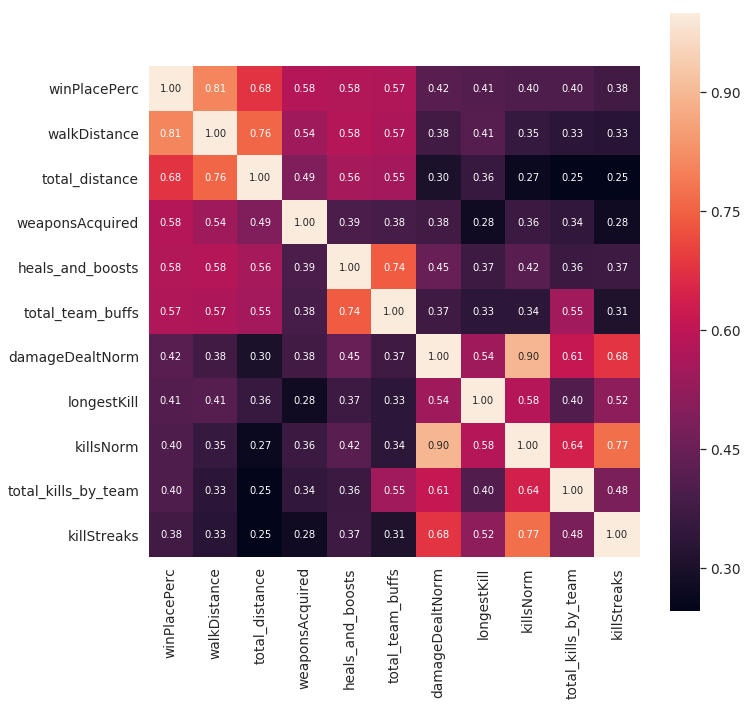

In [38]:
k = 11 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = X_train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(X_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

## Functions:

In [28]:
# Cross-Validation Abosolute Mean Error scoring
def abs_mean_error_cv(model, train_set):
    kf = KFold(5, shuffle=True, random_state=0).get_n_splits(train_set)
    abs_mean_err = cross_val_score(model, train_set, y_train, scoring="neg_mean_absolute_error", cv = kf)
    return abs_mean_err.mean()

In [29]:
# Generates predictions and submission for a given model
def gen_sub(name, model):
    y_pred = model.predict_proba(X_test).T[1]
    solution = pd.DataFrame({"Id":testId, "Y":y_pred})
    solution.to_csv(name +".csv", index = False)

## Models